In [1]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.float_format', '{:.2f}'.format)


df_comp = pd.read_csv("./data_storage/spglobal_data/company.csv")
df_price = pd.read_csv('./data_storage/spglobal_data/company_price.csv')
df = pd.read_csv("./data_storage/portfolio_history.csv")


cash_flow = pd.read_csv('./data_storage/cash_flow.csv').set_index('transaction_date')
ex_rate = pd.read_csv('./data_storage/currency.csv')[['Unnamed: 0', 'KRWUSD']].ffill().rename(columns={'Unnamed: 0': 'date'})
ex_rate['date'] = pd.to_datetime(ex_rate['date'])
cash_flow.index.name = 'date'
cash_flow.index = pd.to_datetime(cash_flow.index)
cash_flow = cash_flow.groupby('date').sum()

map = df_comp[['tradingitemid', 'ticker_symbol']].set_index('tradingitemid').to_dict()['ticker_symbol']
start_date = df['date'].min()
end_date = df['date'].max()


In [2]:


df_price = pd.read_csv('./data_storage/spglobal_data/company_price.csv')

df_price['tickersymbol'] = df_price['tradingitemid'].map(map)
df_price = df_price.rename(columns={'pricingdate':'date'})
df_price= df_price[['date', 'tickersymbol', 'priceclose_raw']]


df_price = df_price.pivot(index='date', columns='tickersymbol', values='priceclose_raw').ffill()
df_price.index = pd.to_datetime(df_price.index)
full_range = pd.date_range(start=df_price.index.min(), end=df_price.index.max(), freq="D")
df_price = df_price.reindex(full_range).ffill()
df_price.index.name = "date"

df_price = pd.melt(df_price.reset_index(), id_vars=['date'], value_vars=df_price.columns, var_name='ticker', value_name='price_close')
df_price


,date,ticker,price_close
0,2019-01-02,A069500,26270.00
1,2019-01-03,A069500,26015.00
2,2019-01-04,A069500,26215.00
3,2019-01-05,A069500,26215.00
4,2019-01-06,A069500,26215.00
...,...,...,...
111820,2025-10-17,UAL,99.14
111821,2025-10-18,UAL,99.14
111822,2025-10-19,UAL,99.14
111823,2025-10-20,UAL,101.29


In [3]:

def expand_portfolio_to_daily(df, end_date=None, freq="D"):
    """
    Expand sparse portfolio snapshots to daily rows by duplicating each snapshot
    until the next snapshot date (exclusive). For the last snapshot, expand up to
    `end_date` (inclusive) if provided.
    """
    out = df.copy()

    # 1) normalize and keep original as snapshot_date
    out['date'] = pd.to_datetime(out['date']).dt.normalize()
    out = out.rename(columns={'date': 'snapshot_date'})

    # 2) compute next snapshot date (exclusive upper bound)
    snaps = pd.Index(sorted(out['snapshot_date'].unique()))
    next_map = {}
    for i, d in enumerate(snaps):
        if i + 1 < len(snaps):
            next_map[d] = snaps[i + 1]  # next snapshot (exclusive)
        else:
            if end_date is not None:
                next_map[d] = pd.to_datetime(end_date).normalize() + pd.Timedelta(days=1)
            else:
                next_map[d] = d + pd.Timedelta(days=1)  # only same day

    out['next_date'] = out['snapshot_date'].map(next_map)

    # 3) build per-row ranges on chosen frequency, inclusive start / exclusive end
    def _make_range(row):
        end_excl = row['next_date'] - pd.Timedelta(days=1)
        rng = pd.date_range(row['snapshot_date'], end_excl, freq=freq)
        # ensure at least one row even if freq skips the day (e.g., B on weekend)
        if len(rng) == 0:
            rng = pd.DatetimeIndex([row['snapshot_date']])
        return rng

    out['date'] = out.apply(_make_range, axis=1)

    # 4) explode to daily rows
    expanded = out.explode('date', ignore_index=True)

    # 5) tidy up — drop helper columns, sort
    expanded.drop(columns=['snapshot_date', 'next_date'], inplace=True)
    if 'ticker' in expanded.columns:
        expanded.sort_values(['date', 'ticker'], inplace=True, ignore_index=True)
    else:
        expanded.sort_values(['date'], inplace=True, ignore_index=True)

    return expanded

In [4]:
df = expand_portfolio_to_daily(df)
df = df[['date', 'ticker', 'type', 'market', 'amount','total_value']]

In [5]:
df_price

,date,ticker,price_close
0,2019-01-02,A069500,26270.00
1,2019-01-03,A069500,26015.00
2,2019-01-04,A069500,26215.00
3,2019-01-05,A069500,26215.00
4,2019-01-06,A069500,26215.00
...,...,...,...
111820,2025-10-17,UAL,99.14
111821,2025-10-18,UAL,99.14
111822,2025-10-19,UAL,99.14
111823,2025-10-20,UAL,101.29


In [6]:
new_df = df.merge(df_price[['date','ticker','price_close']], on=['date', 'ticker'], how='left')

new_df['market_value'] = new_df['price_close'] * new_df['amount']
new_df.loc[new_df['type'] == 'Cash', 'market_value'] = new_df.loc[new_df['type'] == 'Cash', 'total_value']
new_df.loc[new_df['type'] == 'Bond', 'market_value'] = new_df.loc[new_df['type'] == 'Bond', 'total_value']

new_df = new_df.merge(ex_rate, on='date', how='left')
new_df['market_value_won'] = new_df['market_value']
new_df.loc[new_df['market'] == 'US', 'market_value_won'] *= new_df.loc[new_df['market'] == 'US', 'KRWUSD'] 

In [7]:
ndf = new_df.groupby('date').sum()['market_value_won']
ndf

date
2020-03-05      811500.00
2020-03-06      811500.00
2020-03-07      811500.00
2020-03-08      811500.00
2020-03-09      811500.00
                 ...     
2025-09-25   298251535.84
2025-09-26   301686303.96
2025-09-27   301686303.96
2025-09-28   301686303.96
2025-09-29   300609621.95
Name: market_value_won, Length: 2035, dtype: float64

In [8]:
(df['total_value'].pct_change().loc['2020-04-01':] + 1).cumprod().to_csv('cumprod.csv')

/usr/local/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)


In [9]:
plt.figure(figsize=(12, 6))
plt.plot(ndf, linewidth=2)
plt.title('Total Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Return Value (KRW)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('portfolio_value.png')
plt.close()

In [10]:
def get_daily_cum_return(market_value_s:pd.Series, cash_flow_s:pd.Series, sdate=None):    

    ms = market_value_s
    cs = cash_flow_s

    raw_pct_change = ms.pct_change()
 
    df = pd.concat([ms, cs], axis=1)
    df = df.reset_index()
    df.columns = ['date', 'market_value', 'cash_flow']
    
    df['total_value'] = df['market_value'] - df['cash_flow']
    df['pct_change'] = df['total_value'].pct_change()

    cs_dates = cs.index.tolist()

    raw_pct_change[raw_pct_change.index.isin(cs_dates)] = df.loc[df['date'].isin(cs_dates), 'pct_change']

    cum_return = (raw_pct_change+1).cumprod() -1
    
    return cum_return

In [11]:
market_value_s = ndf
cash_flow_s = cash_flow['transaction_amount']

ms = market_value_s
cs = cash_flow_s

raw_pct_change = ms.pct_change()

df = pd.concat([ms, cs], axis=1)
df = df.reset_index()
df.columns = ['date', 'market_value', 'cash_flow']

df['cash_flow'] = df['cash_flow'].fillna(0)
df['total_value'] = df['market_value'] - df['cash_flow']
df['pct_change'] = df['total_value'].pct_change()

cs_dates = cs.index.tolist()

raw_pct_change[raw_pct_change.index.isin(cs_dates)] = df.loc[df['date'].isin(cs_dates), 'pct_change']

cum_return = (raw_pct_change+1).cumprod() -1

#cum_return = get_daily_cum_return(market_value_s, cash_flow_s)

In [12]:
ms = market_value_s.sort_index().astype(float)['2023-01-01': '2024-01-01']
cs = cash_flow_s.reindex(ms.index).fillna(0).astype(float)['2023-01-01': '2024-01-01']

# 일별 TWR 수익률: r_t = (V_t - CF_t)/V_{t-1} - 1
prev_v = ms.shift(1)
daily_twr = (ms - cs) / prev_v - 1

# 첫 날은 분모가 없으니 0 또는 NaN 처리 (보통 0으로 둬서 누적 1.0 시작)
daily_twr.iloc[0] = 0.0

# 누적 TWR
cum_return = (1 + daily_twr).cumprod() - 1

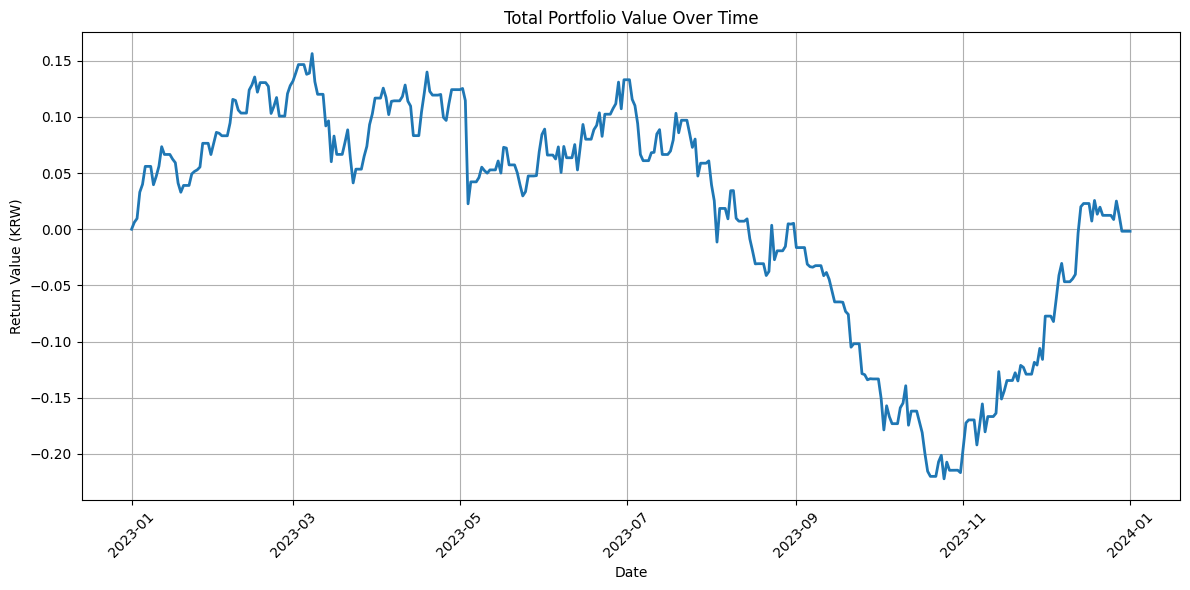

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(cum_return, linewidth=2)
plt.title('Total Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Return Value (KRW)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('portfolio_.png')
plt.show()
plt.close()

cum_return.to_csv('my_return.csv')

In [14]:
new_df.loc[new_df['date'] == '2023-10-30']

,date,ticker,type,market,amount,total_value,price_close,market_value,KRWUSD,market_value_won
15071,2023-10-30,AAL,Stock,US,35.00,582.00,11.18,391.30,1350.90,528607.17
15072,2023-10-30,AAPL,Stock,US,6.00,707.10,170.29,1021.74,1350.90,1380268.57
15073,2023-10-30,ALB,Stock,US,1.00,214.90,127.41,127.41,1350.90,172118.17
15074,2023-10-30,AMZN,Stock,US,9.00,1219.18,132.71,1194.39,1350.90,1613501.45
15075,2023-10-30,BA,Stock,US,6.00,814.26,182.35,1094.10,1350.90,1478019.69
15076,2023-10-30,BAC,Stock,US,11.00,320.32,25.69,282.59,1350.90,381750.83
15077,2023-10-30,C,Stock,US,8.00,371.04,38.93,311.44,1350.90,420724.30
15078,2023-10-30,CCL,Stock,US,24.00,457.40,11.40,273.60,1350.90,369606.24
15079,2023-10-30,DAL,Stock,US,42.00,1481.49,31.23,1311.66,1350.90,1771921.49
15080,2023-10-30,GM,Stock,US,5.00,173.24,27.36,136.80,1350.90,184803.12


In [15]:
tmf_df = new_df.loc[new_df['ticker'] == 'TMF']

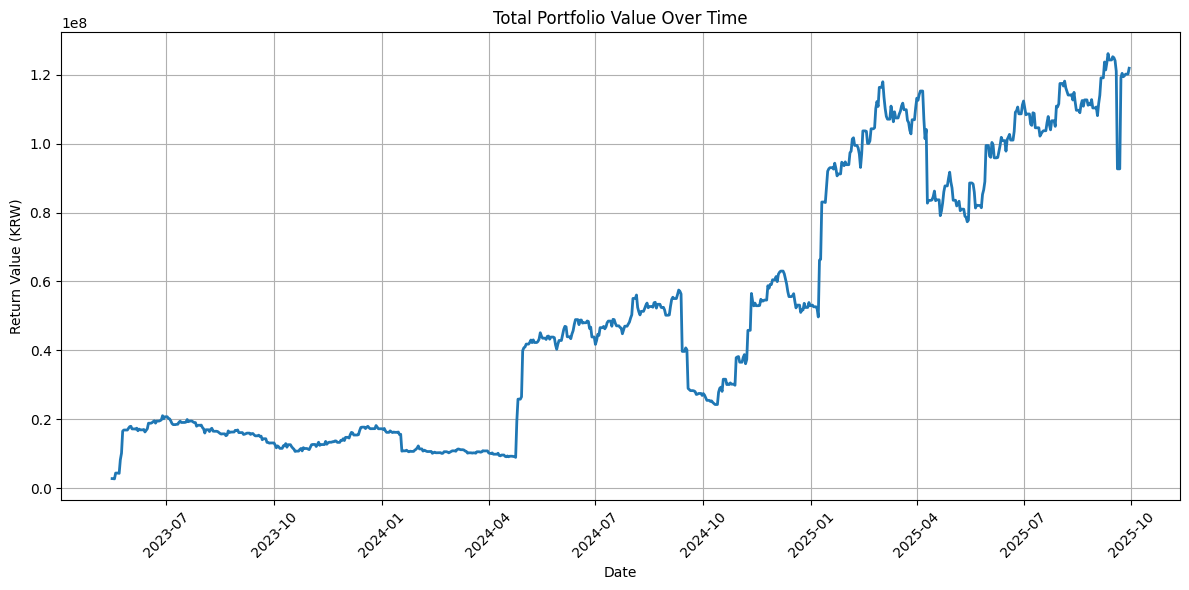

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(tmf_df['date'], tmf_df['market_value_won'], linewidth=2)
plt.title('Total Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Return Value (KRW)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('portfolio_.png')
plt.show()
plt.close()

run_id:  1


/tmp/ipykernel_301773/4290424916.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['run_id'] = is_new_block.cumsum()


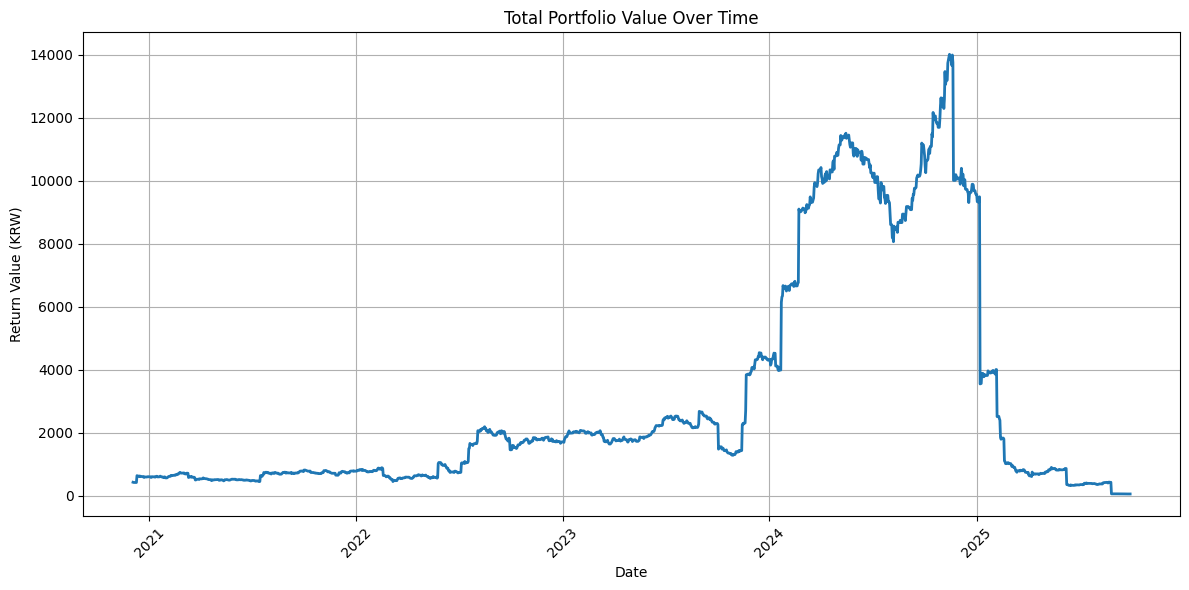

In [17]:
tdf = new_df.loc[new_df['ticker'] == 'DAL']

# 새 구간 시작 여부: 티커가 바뀌었거나, 이전 날짜 + 1일이 아니면 새 구간
is_new_block = (
    tdf['ticker'].ne(tdf['ticker'].shift()) |
    (tdf['date'].diff() != pd.Timedelta(days=1))
)

tdf['run_id'] = is_new_block.cumsum()
run_ids = tdf['run_id'].unique().tolist()

for rid in run_ids:
    print("="*100)
    print("run_id: ", rid)
    ttdf = tdf.loc[tdf['run_id'] == rid]
    plt.figure(figsize=(12, 6))
    plt.plot(ttdf['date'], ttdf['market_value'], linewidth=2)
    plt.title('Total Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Return Value (KRW)')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [18]:
import pandas as pd

import pandas as pd
import numpy as np

def compute_pnl_from_positions(df: pd.DataFrame) -> pd.DataFrame:
    """
    df 컬럼(필수): date, amount, total_value, price_close, market_value
    - amount: 해당 일자 종가 시점의 보유수량
    - total_value: (평균단가 * 보유수량) = 남아있는 '원가총액'(코스트 베이스)
    - price_close: 해당 일자 종가
    - market_value: (price_close * amount)
    """
    out = df.copy()
    out['date'] = pd.to_datetime(out['date'])
    out = out.sort_values('date').reset_index(drop=True)

    # 전일 값들
    out['prev_qty']   = out['amount'].shift()
    out['prev_cost']  = out['total_value'].shift()
    out['prev_close'] = out['price_close'].shift()

    # 전일 평균단가(보유수량이 0이면 NaN)
    out['prev_avg_cost'] = np.where(out['prev_qty'] > 0,
                                    out['prev_cost'] / out['prev_qty'],
                                    np.nan)

    # 수량 변화(>0 매수, <0 매도)
    out['delta_qty'] = out['amount'] - out['prev_qty'].fillna(0)

    # ---------------------------
    # 1) 매수단가 역산 (delta_qty > 0 일때만)
    # new_avg = total_value/amount
    # new_avg = (prev_cost + q_buy * buy_px) / new_qty  -> buy_px = ((new_avg*new_qty) - prev_cost) / q_buy
    new_avg = out['total_value'] / out['amount'].replace(0, np.nan)
    buy_px = ((new_avg * out['amount']) - out['prev_cost']) / out['delta_qty']
    out['buy_px'] = np.where(out['delta_qty'] > 0, buy_px, np.nan)

    # 매수 현금흐름(유출, 음수)
    out['buy_cashflow'] = np.where(out['delta_qty'] > 0,
                                   -out['delta_qty'] * out['buy_px'],
                                   0.0)

    # ---------------------------
    # 2) 매도(종가 체결 가정)
    sell_qty = (-out['delta_qty']).clip(lower=0)  # delta<0일 때 양수화
    out['sell_px'] = np.where(sell_qty > 0, out['price_close'], np.nan)

    # 매도 현금흐름(유입, 양수)
    out['sell_cashflow'] = sell_qty * out['sell_px'].fillna(0.0)

    # 실현손익 = (매도가 - 전일 평균단가) * 매도수량
    out['realized_pnl'] = (out['sell_px'] - out['prev_avg_cost']) * sell_qty
    out['realized_pnl'] = out['realized_pnl'].fillna(0.0)

    # ---------------------------
    # 3) 평가손익(Holding PnL): 전일 보유수량 × (금일종가 - 전일종가)
    out['holding_pnl'] = (out['price_close'] - out['prev_close']) * out['prev_qty']
    out['holding_pnl'] = out['holding_pnl'].fillna(0.0)

    # 일별 총 손익
    out['daily_pnl'] = out['realized_pnl'] + out['holding_pnl']

    # 누적 손익
    out['cumulative_pnl'] = out['daily_pnl'].cumsum()

    # ---------------------------
    # 4) 최종 요약용 파생값들
    # (참고) 마지막 미실현손익 = 마지막 market_value - 마지막 total_value
    last_mv   = out['market_value'].iloc[-1]
    last_cost = out['total_value'].iloc[-1]
    final_unrealized = last_mv - last_cost

    out.attrs['summary'] = {
        'final_realized_pnl': float(out['realized_pnl'].sum()),
        'final_unrealized_pnl': float(final_unrealized),
        'final_total_pnl': float(out['realized_pnl'].sum() + final_unrealized),
    }

    # 현금흐름(매수 유출 + 매도 유입)도 참고용으로 남겨둠 (MWR 계산 등에 활용 가능)
    out['cashflow'] = out['buy_cashflow'] + out['sell_cashflow']

    return out




/tmp/ipykernel_301773/118239096.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['run_id'] = is_new_block.cumsum()


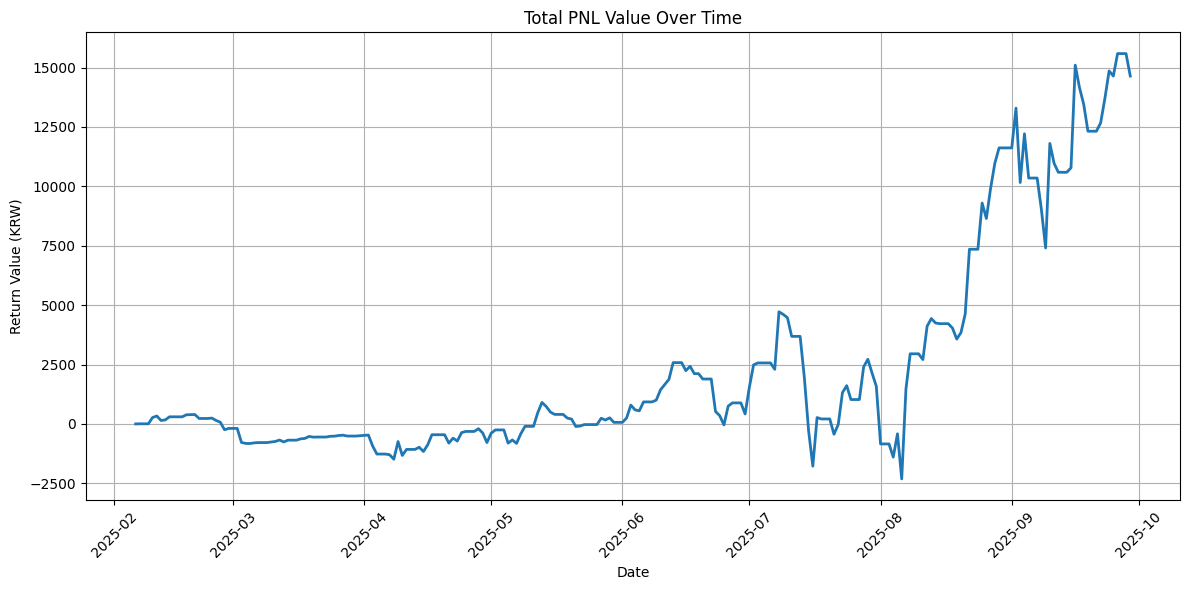

In [29]:
print("="*100)
tdf = new_df.loc[new_df['ticker'] == 'APA']

# 새 구간 시작 여부: 티커가 바뀌었거나, 이전 날짜 + 1일이 아니면 새 구간
is_new_block = (
    tdf['ticker'].ne(tdf['ticker'].shift()) |
    (tdf['date'].diff() != pd.Timedelta(days=1))
)

tdf['run_id'] = is_new_block.cumsum()
run_ids = tdf['run_id'].unique().tolist()

# 사용 예:
result = compute_pnl_from_positions(tdf)
result[['date','amount','price_close','delta_qty','buy_px','sell_px',
        'holding_pnl','realized_pnl','daily_pnl','cumulative_pnl']].head()
result.attrs['summary']  # 최종 요약(총 실현, 미실현, 총손익)

plt.figure(figsize=(12, 6))
plt.plot(result['date'], result['cumulative_pnl'], linewidth=2)
plt.title('Total PNL Value Over Time')
plt.xlabel('Date')
plt.ylabel('Return Value (KRW)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
